In [7]:
# Directories
import os
os.chdir(r"E:\academy\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis")
print(os.getcwd())


E:\academy\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis


In [12]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4
from dask.distributed import Client

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import numpy as np 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as clr
import seaborn 
import scienceplots
import matplotlib.ticker as ticker
#plt.rcParams["font.weight"] = "bold"
plt.style.use(['science','no-latex','bright'])

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy

import xarrayMannKendall as XMK


# 1. Checking MERRA2, IMD, ERA5, CHIRPS

In [54]:
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5"]
ls=[]
for mdl in model:
    lsm_M = xr.open_mfdataset(f"DATA_p/{mdl}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
    lsm_M=lsm_M*60*60*24*30 #converting to mm/ month
    lsm_M=lsm_M[['TotalPrecip_tavg','Qs_tavg']]
    RE=lsm_M["Qs_tavg"]/lsm_M["TotalPrecip_tavg"]
    RE=RE.where(RE<1)  # REMOVING RE>1
    lsm_M['RE']=RE

    ssn_m=[range(1,13),[6,7,8,9],[12,1,2,3,4]]
    months=lsm_M["time.month"]
    lsm_M=lsm_M.sel(time=months.isin(ssn_m[1]))
    
    #TREND ANALYSis

    da=lsm_M["RE"]
    da=da.rename({'lat': 'y', 'lon': 'x'})
    MK_test = XMK.Mann_Kendall_test(da, 'time')
    xrr=MK_test.compute()
    xrr['trend']=xrr.trend.where(xrr.signif==1,0)    #To REMOVE NON SIGNIFICANT POINTS
    ls.append(xrr)


C:\Users\sstar\anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sstar\anaconda3\lib\site-packages\xarrayMannKendall\xarrayMannKendall.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  z = (self.score + 1)/np.sqrt(self.var_s)
C:\Users\sstar\anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_e

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


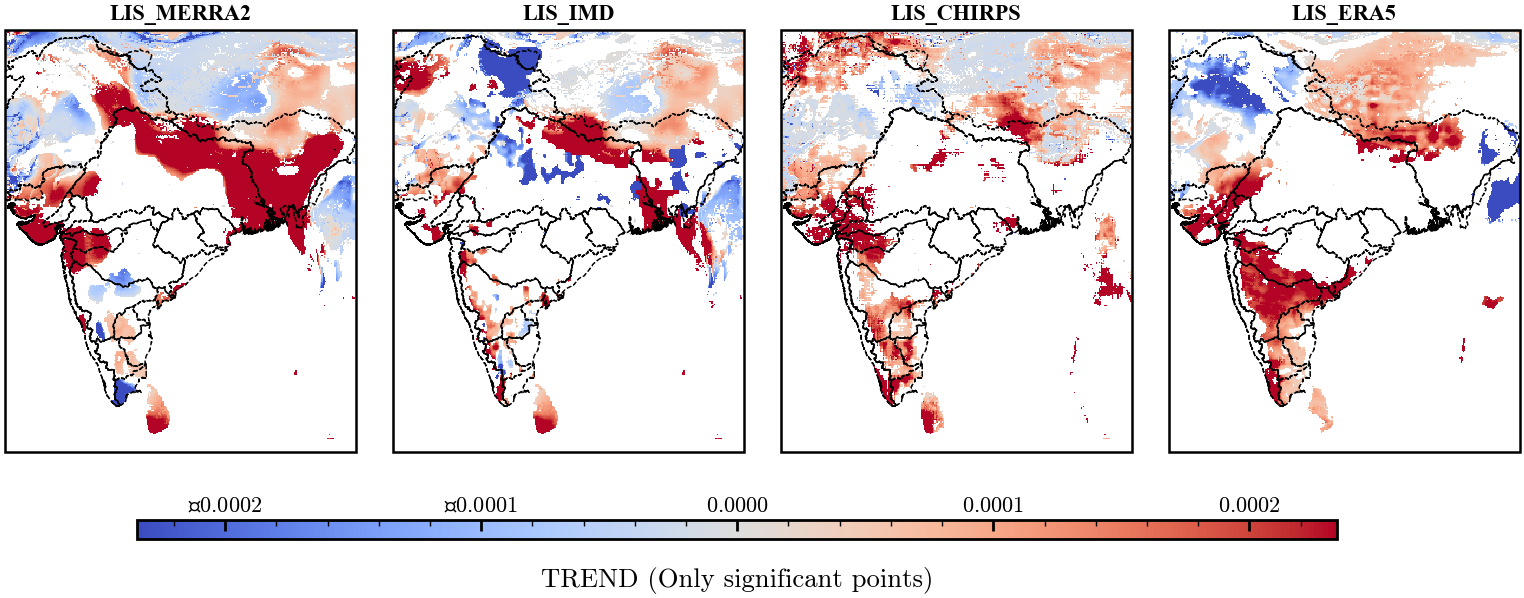

In [58]:
Map_plot1(ls,[1,4],model,'TREND (Only significant points)')    
plt.savefig(f"2_Preliminary analysis/Sign_POINTS.jpeg", bbox_inches='tight')
plt.show()

## Individual analysis

# FUNCTIONS

In [56]:
def Map_plot1(xrr1,col_row,plt_tit,cbar_tit):

    # Define the parameters
    B=5      # THis is the base scale. one figure dimension. All are determined based on this
    
    fig_len=col_row[1]*5
    fig_hg=col_row[0]*5*1.3    #This 1.15 depend on the subplot dimension. This case, height of subplot more than length
    fnt = B*3.2
    pd = B*1.5
    ln_wd = B*0.2
    
    fig, axs = plt.subplots(col_row[0],col_row[1],subplot_kw={'projection': ccrs.PlateCarree()},figsize=(fig_len,fig_hg),constrained_layout=False)
    axs=axs.flatten()

    #Adding feature maps
    basin_map = gpd.read_file('DATA_p/Shapefiles/Indian_basin/India_transboundary.shp')
    ind_map = gpd.read_file('DATA_p/Shapefiles/Indian_map/India_country.shp')

    #define plot variables
    vmin1 = -max(abs(xrr1[0]["trend"].quantile(0.1)), abs(xrr1[0]["trend"].quantile(0.9)))
    vmax1 = -vmin1
    cmap2='coolwarm'

    #Loop over all of the models
    for i,model in enumerate(range(len(xrr))):

            # Axis setttings
            data=xrr1[i]["trend"].where(xrr1[i]["trend"]!=0)

            axs[i].set_extent([67.90, 97.59,4.5, 37.50], ccrs.PlateCarree())
            [x.set_linewidth(1.8) for x in axs[i].spines.values()]        #bOUNDARY WIDTHH 

            #cmap1 = clr.LinearSegmentedColormap.from_list('blue_to_white', ['lightblue', '#FFFFFF'], N=256)
            #gradient = np.linspace(0, 1, 256).reshape(-1, 1)
            #axs[i].imshow(gradient, cmap=cmap1, extent=[67.90, 97.59,4.5, 37.50], transform=ccrs.PlateCarree())    

            axs[i].set_title(f"{plt_tit[i]}",fontsize=fnt,pad=pd,fontname='Times New Roman',weight='bold')

    
            # Adding Mainplo
            Main_plot=data.plot(vmin=vmin1,vmax=vmax1 ,ax=axs[i], cmap=cmap2, add_labels=False, add_colorbar=False) 
            basin_map.plot(ax=axs[i],color = 'none',edgecolor = 'black',linewidth=ln_wd,linestyle='--')



    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=1.5/fig_hg, left=None, top=None, right=None, wspace=0.1/(fig_len), hspace=1.25/fig_hg)  # First lock bottom, while make others None (automatically select), Then change spaces

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.63/fig_hg, 0.6, 0.19/fig_hg])   # left,bottom, widht, height

    # Draw the colorbar
    cbar=fig.colorbar(Main_plot, cax=cbar_ax,orientation='horizontal') #,ticks=[0, 1,5]
    cbar.outline.set_linewidth(2) 
    cbar.ax.tick_params(axis='both',which='both', labelsize=fnt,width=2, length=8) 
    cbar.ax.tick_params(axis='both',which='minor', labelsize=fnt*0.7,width=1, length=4) 
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    cbar.set_label(cbar_tit, fontsize=fnt*1.2, labelpad=-65,weight="bold")#position=(0.5, -0.5)
    cbar.ax.xaxis.label.set_fontweight('bold')
    
    #plt.tight_layout()  
    #plt.show()

In [27]:
vmin1 = -max(abs(ls[0]["trend"].quantile(0.1)), abs(ls[0]["trend"].quantile(0.9)))
vmax1 = -vmin1

In [29]:
vmax1

<xarray.DataArray 'trend' ()>
array(0.00029611)
Coordinates:
    quantile  float64 0.9